Shape of the data: (96, 9)


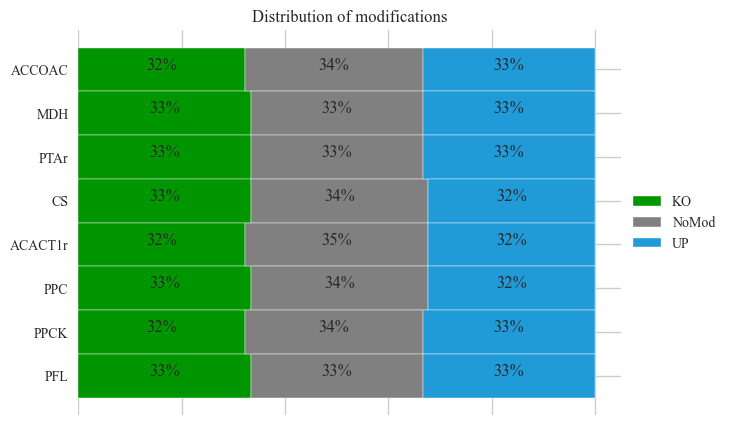

In [1]:
import sys
sys.path.append("../")

import warnings
import pickle
import numpy as np
import pandas as pd
from IPython.display import display
from pycaret.regression import *
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from src import plot_multiomics

warnings.simplefilter(action="ignore", category=FutureWarning)

file_path = "../data/EDD_isoprenol_production.csv"

INPUT_VARS = ["ACCOAC", "MDH", "PTAr", "CS", "ACACT1r", "PPC", "PPCK", "PFL"]
RESPONSE_VARS = ["Value"]

df = pd.read_csv(file_path, index_col=0)
df = df[INPUT_VARS + RESPONSE_VARS]
df[INPUT_VARS] = df[INPUT_VARS].astype(int)
print(f"Shape of the data: {df.shape}")
plot_multiomics.plot_distribution_of_designs(df[INPUT_VARS])

# ML modeling

In [2]:
def bootstrap(X, y, model: object, n: int = 100):
    mae_values = []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.20, random_state=i
        )
        y_pred = model.predict(X_test)
        mae_values.append(mean_absolute_error(y_test, y_pred))
    return mae_values

try:
    final_model = load_model("../models/xgb_isoprenol")
    mae_values = bootstrap(df[INPUT_VARS], df[RESPONSE_VARS], final_model)
    print(f"Bootstraped Mean(MAE) = {np.mean(mae_values)}")
    
except FileNotFoundError:

    def pycaret_train(
        df: pd.DataFrame,
        target: str,
        model_name: str,
        normalize: bool = False,
        verbose: bool = False,
    ):
        s = setup(df, target=target, normalize=normalize, verbose=verbose)
        model = create_model(model_name, cross_validation=True, fold=5, verbose=verbose)
        final_model = tune_model(
            model,
            optimize="MAE",
            fold=5,
            search_library="scikit-optimize",
            n_iter=100,
            search_algorithm="bayesian",
            verbose=verbose,
            tuner_verbose=verbose,
        )
        return final_model

    final_model = pycaret_train(df, "Value", "xgboost", normalize=True, verbose=False)
    mae_values = bootstrap(df[INPUT_VARS], df[RESPONSE_VARS], final_model)
    print(f"Bootstraped Mean(MAE) = {np.mean(mae_values)}")

    with open("../models/xgb_isoprenol.pkl", "wb") as f:
        pickle.dump(final_model, f)

Transformation Pipeline and Model Successfully Loaded


100%|██████████| 100/100 [00:02<00:00, 40.60it/s]

Bootstraped Mean(MAE) = 0.11811677894658423


#### Explainable AI 

2024-02-05 00:54:32.516207: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-05 00:54:32.582539: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-05 00:54:33.196918: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-05 00:54:33.199941: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 00:54:34.897579: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

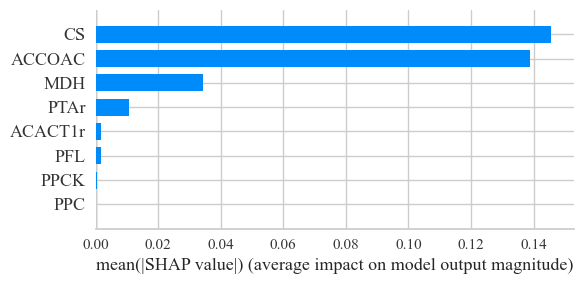

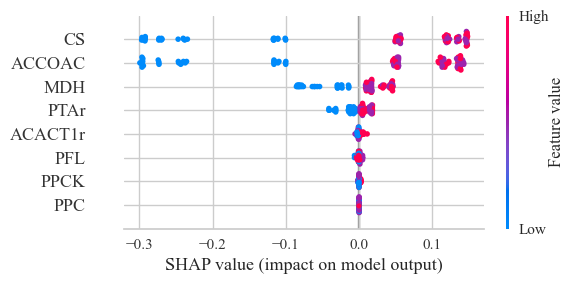

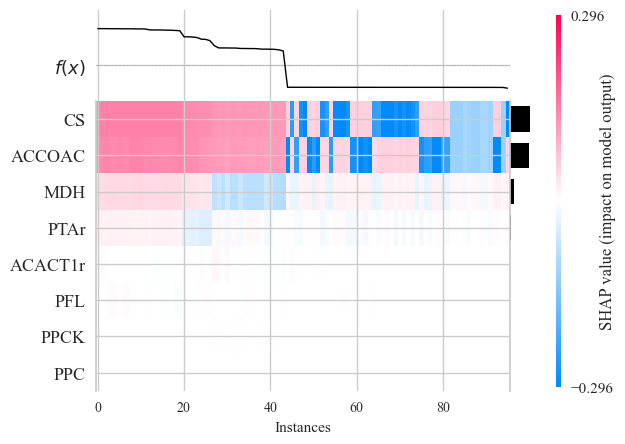

In [3]:
import shap
import matplotlib.pyplot as plt
from alibi.explainers import ALE, PartialDependence, plot_ale, plot_pd

explainer = shap.Explainer(final_model.predict, df[INPUT_VARS])
shap_values = explainer(df[INPUT_VARS])
shap.summary_plot(shap_values, df[INPUT_VARS], plot_type="bar", plot_size=(6, 3))
shap.summary_plot(shap_values, df[INPUT_VARS], plot_type="dot", plot_size=(6, 3))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1), plot_width=6)

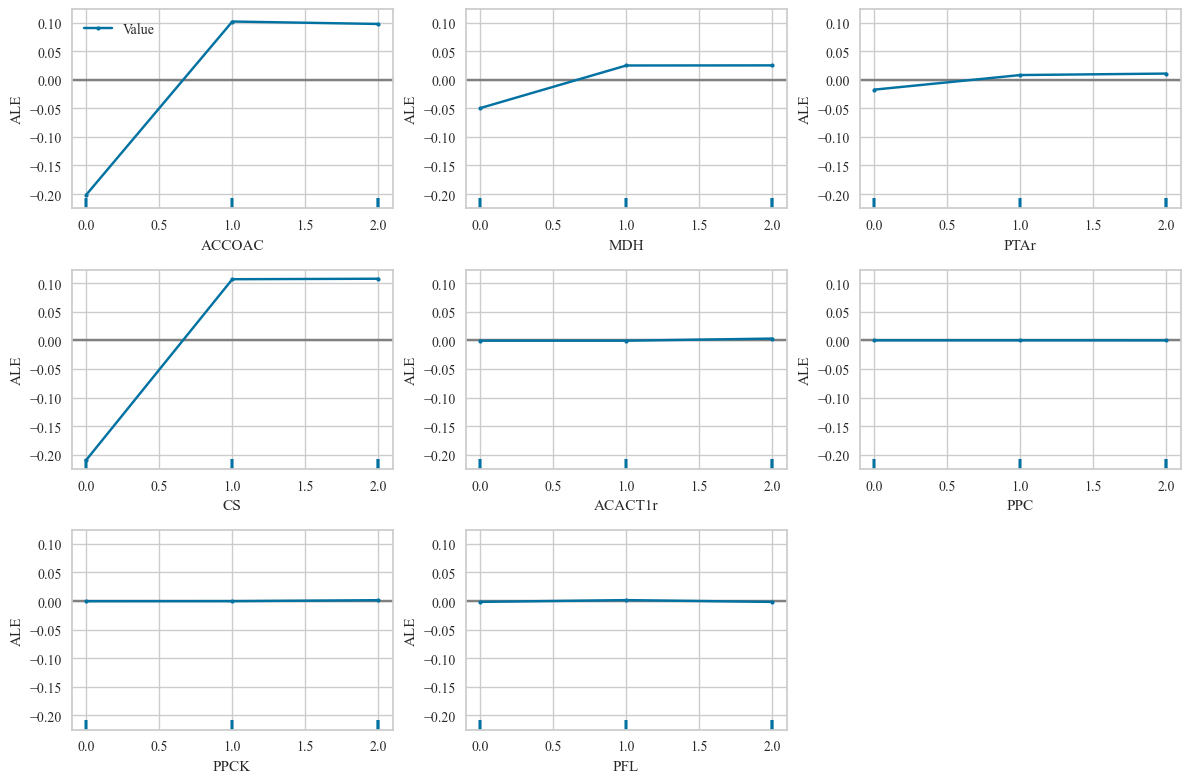

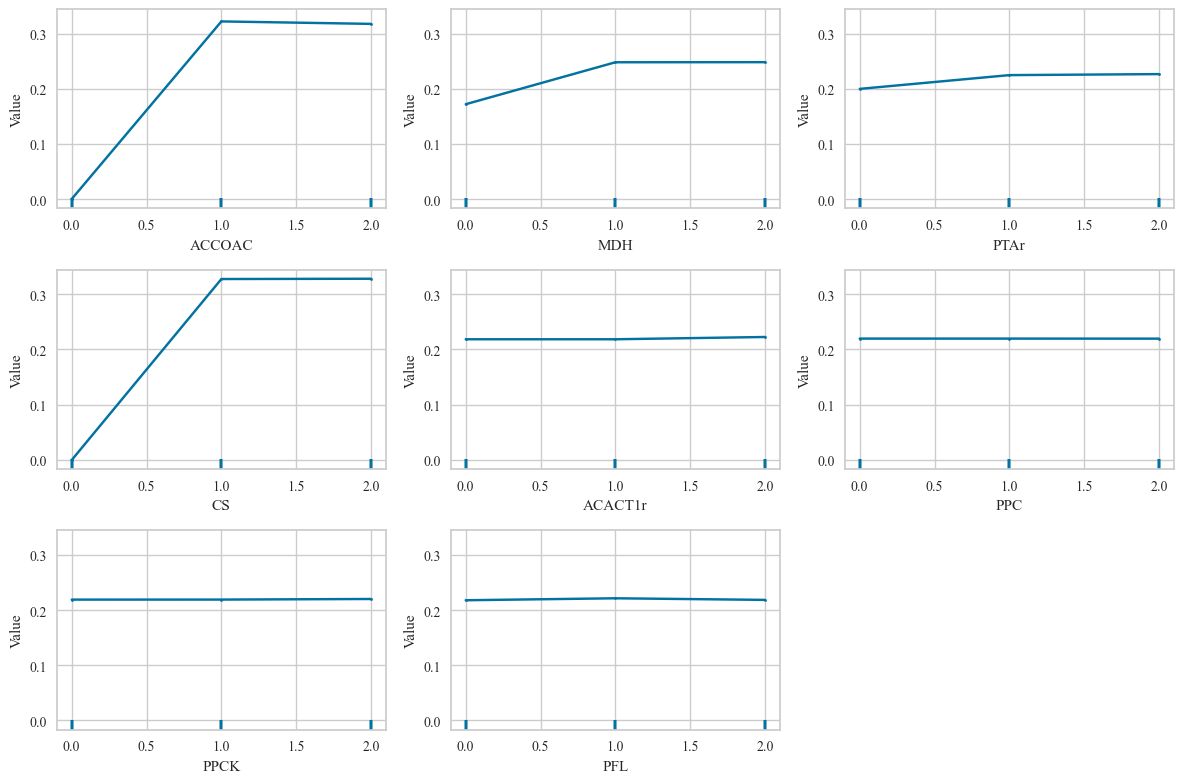

In [4]:
ale = ALE(final_model.predict, feature_names=INPUT_VARS, target_names=RESPONSE_VARS)
exp = ale.explain(df[INPUT_VARS].values)
plot_ale(exp, fig_kw={"figwidth": 12, "figheight": 8})
plt.show()

pdp = PartialDependence(
    predictor=final_model.predict,
    feature_names=INPUT_VARS,
    target_names=RESPONSE_VARS,
    categorical_names=INPUT_VARS,
)
exp = pdp.explain(df[INPUT_VARS].values)
plot_pd(exp, fig_kw={"figwidth": 12, "figheight": 8})
plt.show()

# Supervised clustering

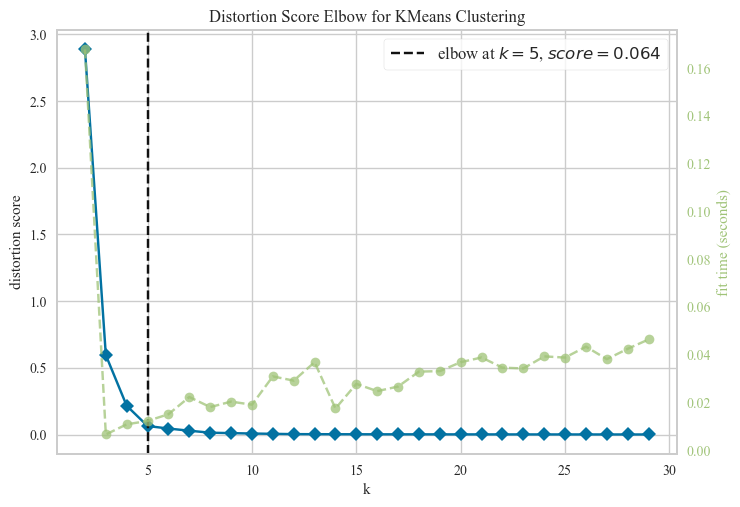

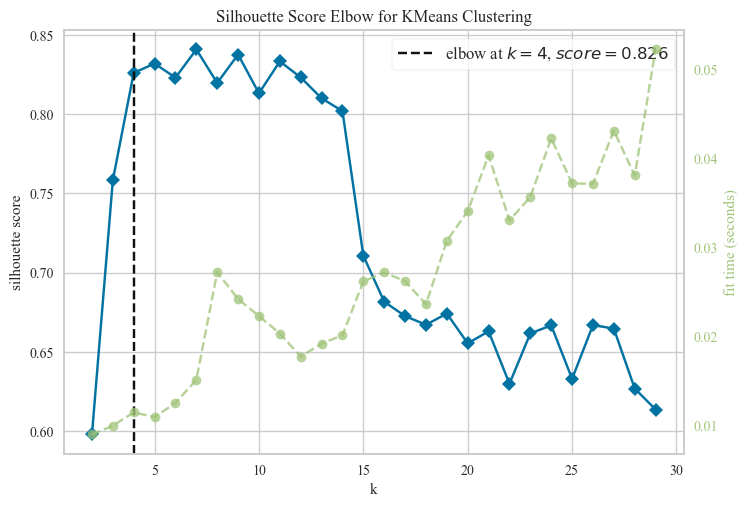

In [5]:
# Elbow Method for K means# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

def elbow_method(shap_values: np.array, model: object = KMeans(), metric: str = "elbow"):
    if metric=='elbow':
        visualizer = KElbowVisualizer(model, k=(2, 30), timings=True)
    else:
        visualizer = KElbowVisualizer(model, k=(2, 30), metric=metric, timings=True)
    visualizer.fit(shap_values)  # Fit data to visualizer
    visualizer.show()  # Finalize and render figure
    return visualizer.elbow_value_
    
def train_clustering(n_clusters: int, model: object = KMeans()):
    cls = model(n_clusters=n_clusters)
    clusters = cls.fit_predict(shap_values.values)
    return clusters


optimal_k_elbow = elbow_method(shap_values.values, model=KMeans())
optimal_k_silh = elbow_method(shap_values.values, model=KMeans(), metric='silhouette')\

clusters = train_clustering(optimal_k_silh, model=KMeans)


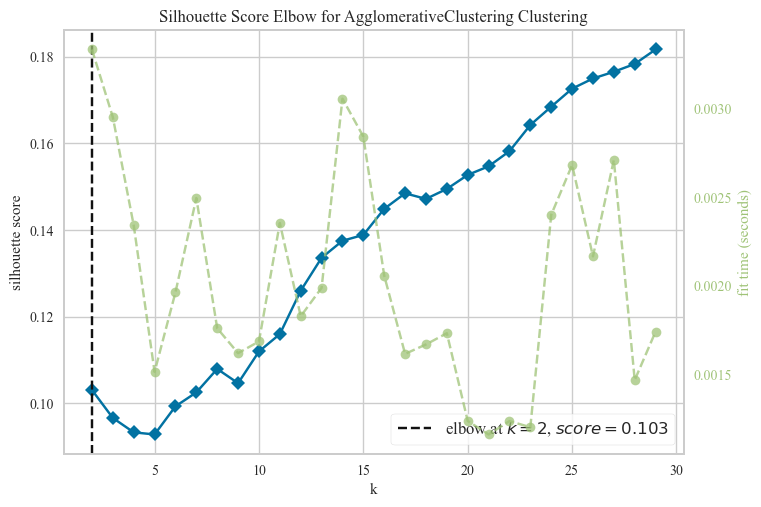

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Value
cluster,,,,,,,,,
0,0.576923,1.038462,0.923077,0.557692,1.0,1.115385,1.000000,0.980769,0.000000
1,1.522727,0.954545,1.090909,1.500000,1.0,0.840909,1.022727,1.022727,0.237623


In [118]:
k = elbow_method(df[INPUT_VARS], model=AgglomerativeClustering(), metric='silhouette')
cls = train_clustering(k, model=AgglomerativeClustering)
df['cluster'] = cls 
# Group by cluster and calculate the mean
df.groupby('cluster').mean().sort_values('Value')



In [125]:
shap_values_df = pd.DataFrame(shap_values.values, columns=INPUT_VARS)
shap_values_df["cluster"] = clusters
shap_values_df['Value'] = df['Value'].values

# Grouping the data by cluster
cluster_means = shap_values_df.groupby('cluster').mean()
cluster_means = cluster_means.sort_values(by='Value', ascending=False)
display(cluster_means)

df['cluster'] = clusters
# Group by cluster and calculate the mean
df.groupby('cluster').median().sort_values('Value')

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Value
cluster,,,,,,,,,
0,0.127380,-0.003848,0.001700,0.134459,-0.000202,0.000010,0.000069,0.000007,0.237623
1,0.050695,0.005628,-0.001908,-0.274683,0.000413,-0.000013,0.000021,0.000157,0.000000
2,-0.272640,0.000830,-0.000939,0.053774,-0.000112,-0.000006,-0.000130,-0.000190,0.000000
3,-0.110593,0.003140,-0.001450,-0.111214,0.000224,-0.000004,-0.000082,0.000016,0.000000


,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Value
cluster,,,,,,,,,
1,1.0,1.0,1.0,0.0,1.0,2.0,2.0,1.0,0.000000
2,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
3,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.000000
0,2.0,1.0,1.0,1.5,1.0,1.0,1.0,1.0,0.109807


# Sampling

In [27]:
sampling_bounds = pd.DataFrame(columns=INPUT_VARS, index=['min', 'max'])
sampling_bounds['ACCOAC'].loc['min'] = 1
sampling_bounds['ACCOAC'].loc['max'] = 2

sampling_bounds['MDH'].loc['min'] = 1
sampling_bounds['MDH'].loc['max'] = 2

sampling_bounds['PTAr'].loc['min'] = 1
sampling_bounds['PTAr'].loc['max'] = 2

sampling_bounds['CS'].loc['min'] = 1
sampling_bounds['CS'].loc['max'] = 2

sampling_bounds['ACACT1r'].loc['min'] = 0
sampling_bounds['ACACT1r'].loc['max'] = 2

sampling_bounds['PPC'].loc['min'] = 0
sampling_bounds['PPC'].loc['max'] = 2

sampling_bounds['PPCK'].loc['min'] = 0
sampling_bounds['PPCK'].loc['max'] = 2

sampling_bounds['PFL'].loc['min'] = 0
sampling_bounds['PFL'].loc['max'] = 2

In [34]:
# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(10)
LB = sampling_bounds.T["min"].values.tolist()
UB = sampling_bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df = sample_df.round(0).astype(int)
sample_df["pred"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)
sample_df

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,pred
0,1,2,0,2,2,1,1,1,0.582315
9,1,2,2,2,2,1,2,0,0.554049
6,0,1,1,2,0,1,1,1,0.493100
1,0,0,0,1,1,1,0,2,0.478643
4,0,0,0,1,0,2,1,0,0.465058
2,1,1,1,1,1,1,1,1,0.462780
3,1,1,1,1,1,0,0,1,0.457005
5,2,0,2,0,1,1,2,2,0.435078
8,2,1,2,0,1,2,1,1,0.431859


## CTGAN

In [9]:
from ctgan import CTGAN

ctgan = CTGAN(epochs=100, embedding_dim=128, generator_dim=(256, 256), discriminator_dim=(256, 256),
              discriminator_lr=0.001, generator_lr=0.001, batch_size=10, log_frequency=True, verbose=True)
ctgan.fit(df[INPUT_VARS], INPUT_VARS)
synthetic_data = ctgan.sample(10000)
synthetic_data['pred'] = final_model.predict(synthetic_data)
synthetic_data.sort_values("pred", ascending=False, inplace=True)
synthetic_data

Gen. (0.96) | Discrim. (1.51): 100%|██████████| 100/100 [00:17<00:00,  5.56it/s] 


,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,pred
994,1,2,2,2,2,0,0,2,0.573937
6153,1,2,2,2,2,0,1,2,0.573937
7028,1,1,2,2,2,1,0,2,0.573937
9790,1,1,1,2,2,0,1,2,0.573937
7161,1,1,1,2,2,1,2,2,0.573937
...,...,...,...,...,...,...,...,...,...
5826,2,0,0,0,1,2,2,2,-0.008316
5875,2,0,2,0,0,2,2,2,-0.008316
9355,2,0,1,0,1,2,1,2,-0.008316
5899,2,0,0,0,0,2,1,2,-0.008316


# Counterfactuals (`DiCE`)

In [16]:
import dice_ml
from dice_ml.utils import helpers

sorted_idx = df.sort_values("Value", ascending=False).index
df[INPUT_VARS] = df[INPUT_VARS].loc[sorted_idx]


def bounds_to_dict(bounds: pd.DataFrame):
    bounds_dict = bounds.to_dict()
    bounds_dict = {k: [v["min"], v["max"]] for k, v in bounds_dict.items()}
    return bounds_dict


query_instances = df[INPUT_VARS][0:1]

d = dice_ml.Data(
    dataframe=df, continuous_features=INPUT_VARS, outcome_name=RESPONSE_VARS[0]
)
m = dice_ml.Model(model=final_model, backend="sklearn", model_type="regressor")
exp = dice_ml.Dice(d, m, method="genetic")
e1 = exp.generate_counterfactuals(query_instances, total_CFs=4, desired_range=[0.50, 1])

cf_df = e1.cf_examples_list[0].final_cfs_df
e1.visualize_as_dataframe(show_only_changes=True)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

Query instance (original outcome : 0.5216761231422424)


,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Value
0,1,1,2,0,2,0,0,0,0.521676



Diverse Counterfactual set (new outcome: [0.5, 1])


,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Value
0,-,-,-,-,-,-,-,-,-
0,0.0,-,-,-,-,-,-,-,-
0,-,-,0.0,-,-,-,-,-,0.5455505847930908
0,-,-,-,-,-,2.0,-,-,0.5213491320610046
